# Eletrochemical nucelation  and Growth (preliminary development)

This is a preliminary model which uses the theory of Electrochemical Nucleation and Growth and attempts to appliy it to battery systems.  For the initial stage of the model, which takes the galvanostatic equations for growth provided in Isaev et al (1), and nucleation was provided by (2). It might someday merge the battery infratructure you provided to examine change in voltage with a constant current.  I will track the variables of radial growth and voltage.  To support this, I will also track avaliable surface area.  This model assume hemispherical growth.  It also assumes diffusion limited current change.

## Part 1: Disclaimer

Basically I just took equations and threw them in there!  The code runs! I didn't do anything to check if its right!  Who knows! Maybe I'll do that before I turn in the final project, probably. 


## Part 2:  Electrochemical Nucleation Equations

All of the equations here are based on (2). I think the best way to start is to say that the nucleation rate is given as 

$J =z_n B(g_c)\Gamma e^{-\frac{G(g_c)}{kT}}$

so let's break down all those terms! $Z_n$ is the Zeldovich factor:

$z_n^2 = -\frac{1}{2\pi kT} \left( \frac{\partial^2 G}{\partial g^2} \right)$

Well whats that?  According to the paper $G(g) = - ze\eta g + b g^(2/3)$ where g is the cluster size.

$\frac{\partial^2 G}{\partial g^2} = -\frac{2}{6} b g^{-\frac{4}{3}}$

All good and well, whats b?

$b=(18 \pi v^2)^(1/3)*\sigma$

Great, we're done with the first term.  time to go with $B(g_c)$.  First we should probably find $g_c$ first tho. That's when $\frac{\partial G}{\partial g} = 0$.

$g_c = \left( \frac{ze\eta}{b}\right)^{-3}$

$B(g_c) = \frac{i_0 s(g_c)}{ze}$

We can calculate the area (s) using the critical radius.  That should give us everything we need to calculate J! 


## Part 3:  Electrochemical Growth Equations

The model starts by assuming a certain overpotential, and then examining the change in overpotential the nucleation and growth undergoes. All properties were taken from (3), while the equations were taken from (1)

First, the current was calcuated using the assumption that transport was diffusion limited

$i =\frac{zec_0}{r}\left[1 - e^{-f\eta} \right]$

Where $f = \frac{ze}{k_b T}$, in these equations, z is the charge transfer, r is the radius, $\eta$ is the overpotential, e is the elementary charge, T is the temperature, and $k_b$ is Botzmann's constant.

The change in radius was modeled by the equation 

$\frac{dr}{dt} = \frac{i*v}{ze}$

Where v, the volume of the molecule was calculated using the molecular weight and density of $Li_2O_2$

The voltage drop was calcualted using the equation:

$\frac{d\eta}{dt} = \frac{i_0-\frac{2\pi r^2 i}{A}}{C_d +zef\Gamma e^{f\eta}}$

Here, $i_0$ is the exchange current density, A is the area, $C_d$ is the specific capacitence of the double layer and $\Gamma$ is the adatom concentrations.  For this part of the assignment, I just used the capcitence and adatom concentration given in the paper, but I'll look into it more for the next iteration.

(1) V. Isaev, O. V. Grishenkova and Y. Zaykov, "Theoretical modeling of electrochemical nucleation and growth of a single metal nanocluster on a nanoelectrode," RCS Adv., vol. 10, pp. 6976-6984, 2020. 

(2) V. Isaev and O. Grishenkova, "Kinetics of electrochemical nucleation and growth," Electrochemicsty Communications, vol. 3, pp. 500-504, 2001. 

(3) J. Li, Z. Su, T. Zhang, Q. Li, M. Yu, X. Zhang and H. Sun, "Highly Efficient Li-Air Battery Using Ultra-Thin Air Electrode," Journal of the Electrochemical Society, vol. 166, no. 5, pp. A3606-A3614, 2019. 

## Part 4:  Future steps

My priorities are as follows:

A: Add the averaged portion to account for more sophisticated nucelation and growth.

B: Validate the model by comparing it to literature versions.

C: Compare this to the conventional nucleation and growth model used for batteries.

### Import modules:

In [1]:
import numpy as np
from math import exp, pi
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt

### Constants

In [2]:
# Constants
F = 96485
R = 8.3145
AN = 6.0221E23 #avogadro's number
k_B = 1.38064852E-23 #boltzmann's constant
e = F/AN #elementary charge

### Inputs

In [3]:
C_rate = 0.1 # How many charges per hour?
N_0 = 0 #number of initial nucleations.
alpha =0.5 #assumed value
T = 298 # K
D_Li = 3.21  #https://www.cell.com/cms/10.1016/j.joule.2018.11.016/attachment/b036fef4-0b6b-4922-9d3d-30736fd991e6/mmc1
OCV = 4 #V
i_0 =4E60 #A/m^2
rho = 2140 #kg/m3 density Li2O2 #https://iopscience.iop.org/article/10.1149/2.0351915jes/pdf
MW =  45.881/1000 #g/mol to kg/mol
sigma = 0.54 #J / m² #surface tension of electrolyte/cluster interface.
z = 1
c_st = 0.10
c_0 = 0.09 #saturated Li2O2 according to this paper https://iopscience.iop.org/article/10.1149/2.0351915jes/pdf
C_d = 80*(100*100)/1000 #microF/cm2 to microF/m2 to F/m2 https://pubs.rsc.org/en/content/articlelanding/2020/ra/d0ra00608d#!divAbstract
gamma_G = 1.2E13*100*100 #cm^2 to m2 adatom concentration, not sure what this is but took literature value ^


### Calculated

In [4]:
A_vol = MW/(AN*rho) #m3/molecule
r_c = 2*sigma*A_vol/(z*e*OCV) + (A_vol*3/(4*pi))**(1/3) #m
A_c = 2*pi*r_c**2
b = (18*pi*A_vol**2)**(1/3)*sigma
G_c = (z*e*OCV/b)**(-3)

Area = 2*pi*r_c**2*50 #test area approximately ten times the nucleation
initial = [OCV, r_c, Area, N_0]
print(initial)
time_of =np.array([0,10])

[4, 3.009316877486553e-08, 2.8450225588961233e-13]


### Running Solution


In [7]:

def residual1(t,SV):
    #intial calcs
    V, r, A, N = SV
    n_p = 2*sigma*A_vol/(z*e*r)
    f_place = z*e/(k_B*T)
    i_dif = z*e*c_0*D_Li/r*(1-exp(-f_place*V))
    G_g= -z*e*V*G_c+b*G_c*(2/3)
    z_n = (-1/(2*pi*k_B*T))*(-2/6)*G_c**(-4/3)
    B_g=i_0*A_vol/(z*e)
    #differential
    dr_dt =  i_dif*A_vol/(z*e)
    dN_dt = z_n*B_g*gamma_G*exp(-G_g/(k_B*T))
    dA_dt = -(N*dr_dt*2*pi*r + dN_dt*A_c)
    dV_dt = -(i_0 - 2*pi*r**2*i_dif/A)/(C_d +z*e*f_place*gamma_G*exp(f_place*(OCV)))
    print(dV_dt)
    return [dV_dt, dr_dt, dA_dt, dN_dt]

solution1 = solve_ivp(residual1,time_of,initial)

voltage_change = solution1.y[0]
radius_change = solution1.y[1]
Area_change = solution1.y[2]
Nucleation_change = solution1.y[3]
final_time = solution1.t

-1.2008163815370536e-07
-1.2008163815370536e-07
-1.2008163815370536e-07
-1.2008163815370536e-07
-1.2008163815370536e-07
-1.2008163815370536e-07
-1.2008163815370536e-07
-1.2008163815370536e-07


Text(0, 0.5, 'Radius (m)')

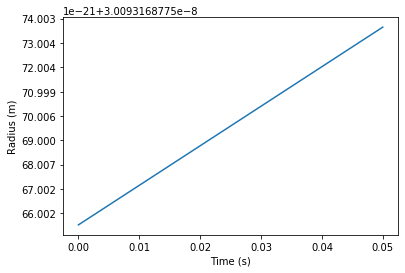

In [8]:
plt.figure(0)
plt.plot(final_time,radius_change)
plt.xlabel("Time (s)")
plt.ylabel("Radius (m)")